## Pretrained Vectors - Absolute Difference (L1)

We train traditional (non neural network) classifiers from Scikit-Learn by looking up the vectors for each given image pair. These image vectors were [generated using pre-trained networks from Keras Model Zoo](http://localhost:8888/notebooks/pretrained-nets-vectorizers.ipynb). In this notebook, we merge the vectors for the image pair by computing the absolute difference (L1) between them.

In [1]:
from __future__ import division, print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
DATA_DIR = "../data"
IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos")

In [3]:
def get_holiday_triples(image_dir):
    image_groups = {}
    for image_name in os.listdir(image_dir):
        base_name = image_name[0:-4]
        group_name = base_name[0:4]
        if image_groups.has_key(group_name):
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples

def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "rb")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def preprocess_data(vector_file, train_size=0.7):
    xdata, ydata = [], []
    vec_dict = load_vectors(vector_file)
    for image_triple in image_triples:
        X1 = vec_dict[image_triple[0]]
        X2 = vec_dict[image_triple[1]]
#         xdata.append(np.multiply(X1, X2) / (np.linalg.norm(X1, 2) * np.linalg.norm(X2, 2)))
        xdata.append(np.abs(np.subtract(X1, X2)))
        ydata.append(image_triple[2])
    X, y = np.array(xdata), np.array(ydata)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    return Xtrain, Xtest, ytrain, ytest

def cross_validate(X, y, clf, k=10):
    best_score, best_clf = 0.0, None
    kfold = KFold(k)
    for kid, (train, test) in enumerate(kfold.split(X, y)):
        Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
        clf.fit(Xtrain, ytrain)
        ytest_ = clf.predict(Xtest)
        score = accuracy_score(ytest_, ytest)
        print("fold {:d}, score: {:.3f}".format(kid, score))
        if score > best_score:
            best_score = score
            best_clf = clf
    return best_clf, best_score

def test_report(clf, Xtest, ytest):
    ytest_ = clf.predict(Xtest)
    print("\nAccuracy Score: {:.3f}".format(accuracy_score(ytest_, ytest)))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytest_, ytest))
    print("\nClassification Report")
    print(classification_report(ytest_, ytest))
    
def get_model_file(data_dir, vec_name, clf_name):
    return os.path.join(data_dir, "models", "{:s}-{:s}-l1.pkl"
                        .format(vec_name, clf_name))

def save_model(model, model_file):
    joblib.dump(model, model_file)

In [4]:
image_triples = get_holiday_triples(IMAGE_DIR)

Generated 0 pos + 0 neg = 0 total image triples
Generated 300 pos + 300 neg = 600 total image triples
Generated 1100 pos + 1100 neg = 2200 total image triples
Generated 1800 pos + 1800 neg = 3600 total image triples
Generated 2072 pos + 2072 neg = 4144 total image triples


In [5]:
NUM_VECTORIZERS = 5
NUM_CLASSIFIERS = 4
scores = np.zeros((NUM_VECTORIZERS, NUM_CLASSIFIERS))

# VGG-16 Vectors

In [6]:
VECTOR_FILE = os.path.join(DATA_DIR, "vgg16-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 4096) (1244, 4096) (2900,) (1244,)


## Naive Bayes

In [7]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "nb"))

fold 0, score: 0.872
fold 1, score: 0.807
fold 2, score: 0.841
fold 3, score: 0.807
fold 4, score: 0.803
fold 5, score: 0.834
fold 6, score: 0.828
fold 7, score: 0.866
fold 8, score: 0.821
fold 9, score: 0.852

Accuracy Score: 0.815

Confusion Matrix
[[554 165]
 [ 65 460]]

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.77      0.83       719
          1       0.74      0.88      0.80       525

avg / total       0.83      0.82      0.82      1244



## SVM

In [8]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "svm"))

fold 0, score: 0.876
fold 1, score: 0.866
fold 2, score: 0.886
fold 3, score: 0.903
fold 4, score: 0.879
fold 5, score: 0.907
fold 6, score: 0.914
fold 7, score: 0.886
fold 8, score: 0.866
fold 9, score: 0.876

Accuracy Score: 0.887

Confusion Matrix
[[527  49]
 [ 92 576]]

Classification Report
             precision    recall  f1-score   support

          0       0.85      0.91      0.88       576
          1       0.92      0.86      0.89       668

avg / total       0.89      0.89      0.89      1244



## XGBoost

In [9]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "xgb"))

fold 0, score: 0.921
fold 1, score: 0.903
fold 2, score: 0.907
fold 3, score: 0.903
fold 4, score: 0.941
fold 5, score: 0.959
fold 6, score: 0.938
fold 7, score: 0.924
fold 8, score: 0.928
fold 9, score: 0.921

Accuracy Score: 0.919

Confusion Matrix
[[573  55]
 [ 46 570]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.91      0.92       628
          1       0.91      0.93      0.92       616

avg / total       0.92      0.92      0.92      1244



## Random Forest

In [10]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "rf"))

fold 0, score: 0.910
fold 1, score: 0.848
fold 2, score: 0.910
fold 3, score: 0.859
fold 4, score: 0.879
fold 5, score: 0.907
fold 6, score: 0.872
fold 7, score: 0.859
fold 8, score: 0.876
fold 9, score: 0.859

Accuracy Score: 0.844

Confusion Matrix
[[573 148]
 [ 46 477]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.79      0.86       721
          1       0.76      0.91      0.83       523

avg / total       0.86      0.84      0.85      1244



# VGG-19

In [11]:
VECTOR_FILE = os.path.join(DATA_DIR, "vgg19-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 4096) (1244, 4096) (2900,) (1244,)


## Naive Bayes

In [12]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "nb"))

fold 0, score: 0.841
fold 1, score: 0.814
fold 2, score: 0.859
fold 3, score: 0.828
fold 4, score: 0.828
fold 5, score: 0.841
fold 6, score: 0.797
fold 7, score: 0.807
fold 8, score: 0.834
fold 9, score: 0.831

Accuracy Score: 0.807

Confusion Matrix
[[518 150]
 [ 90 486]]

Classification Report
             precision    recall  f1-score   support

          0       0.85      0.78      0.81       668
          1       0.76      0.84      0.80       576

avg / total       0.81      0.81      0.81      1244



## SVM

In [13]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "svm"))

fold 0, score: 0.869
fold 1, score: 0.903
fold 2, score: 0.924
fold 3, score: 0.859
fold 4, score: 0.897
fold 5, score: 0.883
fold 6, score: 0.879
fold 7, score: 0.893
fold 8, score: 0.897
fold 9, score: 0.852

Accuracy Score: 0.874

Confusion Matrix
[[506  55]
 [102 581]]

Classification Report
             precision    recall  f1-score   support

          0       0.83      0.90      0.87       561
          1       0.91      0.85      0.88       683

avg / total       0.88      0.87      0.87      1244



## XGBoost

In [14]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "xgb"))

fold 0, score: 0.948
fold 1, score: 0.924
fold 2, score: 0.924
fold 3, score: 0.928
fold 4, score: 0.924
fold 5, score: 0.910
fold 6, score: 0.921
fold 7, score: 0.921
fold 8, score: 0.931
fold 9, score: 0.931

Accuracy Score: 0.917

Confusion Matrix
[[558  53]
 [ 50 583]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.91      0.92       611
          1       0.92      0.92      0.92       633

avg / total       0.92      0.92      0.92      1244



## Random Forest

In [15]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "rf"))

fold 0, score: 0.879
fold 1, score: 0.866
fold 2, score: 0.890
fold 3, score: 0.852
fold 4, score: 0.897
fold 5, score: 0.883
fold 6, score: 0.845
fold 7, score: 0.862
fold 8, score: 0.859
fold 9, score: 0.828

Accuracy Score: 0.858

Confusion Matrix
[[549 118]
 [ 59 518]]

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.82      0.86       667
          1       0.81      0.90      0.85       577

avg / total       0.86      0.86      0.86      1244



# Inception V3

In [16]:
VECTOR_FILE = os.path.join(DATA_DIR, "inception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 2048) (1244, 2048) (2900,) (1244,)


## Naive Bayes

In [17]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "nb"))

fold 0, score: 0.886
fold 1, score: 0.869
fold 2, score: 0.859
fold 3, score: 0.893
fold 4, score: 0.883
fold 5, score: 0.876
fold 6, score: 0.903
fold 7, score: 0.862
fold 8, score: 0.907
fold 9, score: 0.907

Accuracy Score: 0.896

Confusion Matrix
[[607 108]
 [ 21 508]]

Classification Report
             precision    recall  f1-score   support

          0       0.97      0.85      0.90       715
          1       0.82      0.96      0.89       529

avg / total       0.91      0.90      0.90      1244



## SVM

In [18]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "svm"))

fold 0, score: 0.903
fold 1, score: 0.883
fold 2, score: 0.903
fold 3, score: 0.879
fold 4, score: 0.866
fold 5, score: 0.862
fold 6, score: 0.910
fold 7, score: 0.903
fold 8, score: 0.890
fold 9, score: 0.907

Accuracy Score: 0.892

Confusion Matrix
[[536  42]
 [ 92 574]]

Classification Report
             precision    recall  f1-score   support

          0       0.85      0.93      0.89       578
          1       0.93      0.86      0.90       666

avg / total       0.90      0.89      0.89      1244



## XGBoost

In [19]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "xgb"))

fold 0, score: 0.903
fold 1, score: 0.931
fold 2, score: 0.907
fold 3, score: 0.931
fold 4, score: 0.928
fold 5, score: 0.941
fold 6, score: 0.962
fold 7, score: 0.938
fold 8, score: 0.952
fold 9, score: 0.938

Accuracy Score: 0.937

Confusion Matrix
[[593  43]
 [ 35 573]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.93      0.94       636
          1       0.93      0.94      0.94       608

avg / total       0.94      0.94      0.94      1244



## Random Forest

In [20]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "rf"))

fold 0, score: 0.866
fold 1, score: 0.859
fold 2, score: 0.845
fold 3, score: 0.869
fold 4, score: 0.852
fold 5, score: 0.872
fold 6, score: 0.879
fold 7, score: 0.876
fold 8, score: 0.893
fold 9, score: 0.859

Accuracy Score: 0.866

Confusion Matrix
[[592 131]
 [ 36 485]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.82      0.88       723
          1       0.79      0.93      0.85       521

avg / total       0.88      0.87      0.87      1244



# ResNet 50

In [21]:
VECTOR_FILE = os.path.join(DATA_DIR, "resnet-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 2048) (1244, 2048) (2900,) (1244,)


## Naive Bayes

In [22]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "nb"))

fold 0, score: 0.862
fold 1, score: 0.848
fold 2, score: 0.848
fold 3, score: 0.817
fold 4, score: 0.814
fold 5, score: 0.831
fold 6, score: 0.831
fold 7, score: 0.831
fold 8, score: 0.852
fold 9, score: 0.866

Accuracy Score: 0.841

Confusion Matrix
[[553 121]
 [ 77 493]]

Classification Report
             precision    recall  f1-score   support

          0       0.88      0.82      0.85       674
          1       0.80      0.86      0.83       570

avg / total       0.84      0.84      0.84      1244



## SVM

In [23]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "svm"))

fold 0, score: 0.910
fold 1, score: 0.938
fold 2, score: 0.921
fold 3, score: 0.890
fold 4, score: 0.900
fold 5, score: 0.893
fold 6, score: 0.893
fold 7, score: 0.910
fold 8, score: 0.893
fold 9, score: 0.907

Accuracy Score: 0.918

Confusion Matrix
[[558  30]
 [ 72 584]]

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.95      0.92       588
          1       0.95      0.89      0.92       656

avg / total       0.92      0.92      0.92      1244



## XGBoost

In [24]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "xgb"))

fold 0, score: 0.952
fold 1, score: 0.948
fold 2, score: 0.924
fold 3, score: 0.928
fold 4, score: 0.938
fold 5, score: 0.962
fold 6, score: 0.934
fold 7, score: 0.934
fold 8, score: 0.928
fold 9, score: 0.948

Accuracy Score: 0.941

Confusion Matrix
[[587  30]
 [ 43 584]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.95      0.94       617
          1       0.95      0.93      0.94       627

avg / total       0.94      0.94      0.94      1244



## Random Forest

In [25]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "rf"))

fold 0, score: 0.869
fold 1, score: 0.859
fold 2, score: 0.859
fold 3, score: 0.810
fold 4, score: 0.862
fold 5, score: 0.893
fold 6, score: 0.866
fold 7, score: 0.828
fold 8, score: 0.869
fold 9, score: 0.841

Accuracy Score: 0.846

Confusion Matrix
[[580 142]
 [ 50 472]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.80      0.86       722
          1       0.77      0.90      0.83       522

avg / total       0.86      0.85      0.85      1244



# Xception

In [26]:
VECTOR_FILE = os.path.join(DATA_DIR, "xception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 2048) (1244, 2048) (2900,) (1244,)


## Naive Bayes

In [27]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "nb"))

fold 0, score: 0.869
fold 1, score: 0.855
fold 2, score: 0.869
fold 3, score: 0.859
fold 4, score: 0.886
fold 5, score: 0.869
fold 6, score: 0.855
fold 7, score: 0.859
fold 8, score: 0.817
fold 9, score: 0.866

Accuracy Score: 0.867

Confusion Matrix
[[578 124]
 [ 41 501]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.82      0.88       702
          1       0.80      0.92      0.86       542

avg / total       0.88      0.87      0.87      1244



## SVM

In [28]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "svm"))

fold 0, score: 0.938
fold 1, score: 0.907
fold 2, score: 0.924
fold 3, score: 0.928
fold 4, score: 0.952
fold 5, score: 0.921
fold 6, score: 0.948
fold 7, score: 0.934
fold 8, score: 0.917
fold 9, score: 0.921

Accuracy Score: 0.920

Confusion Matrix
[[560  41]
 [ 59 584]]

Classification Report
             precision    recall  f1-score   support

          0       0.90      0.93      0.92       601
          1       0.93      0.91      0.92       643

avg / total       0.92      0.92      0.92      1244



## XGBoost

In [29]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "xgb"))

fold 0, score: 0.941
fold 1, score: 0.917
fold 2, score: 0.938
fold 3, score: 0.941
fold 4, score: 0.952
fold 5, score: 0.931
fold 6, score: 0.938
fold 7, score: 0.938
fold 8, score: 0.903
fold 9, score: 0.921

Accuracy Score: 0.920

Confusion Matrix
[[578  59]
 [ 41 566]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.91      0.92       637
          1       0.91      0.93      0.92       607

avg / total       0.92      0.92      0.92      1244



## Random Forest

In [30]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "rf"))

fold 0, score: 0.855
fold 1, score: 0.841
fold 2, score: 0.838
fold 3, score: 0.814
fold 4, score: 0.876
fold 5, score: 0.879
fold 6, score: 0.848
fold 7, score: 0.859
fold 8, score: 0.803
fold 9, score: 0.848

Accuracy Score: 0.857

Confusion Matrix
[[570 129]
 [ 49 496]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.82      0.86       699
          1       0.79      0.91      0.85       545

avg / total       0.87      0.86      0.86      1244



In [31]:
scores

array([[ 0.87241379,  0.9137931 ,  0.95862069,  0.91034483],
       [ 0.85862069,  0.92413793,  0.94827586,  0.89655172],
       [ 0.90689655,  0.91034483,  0.96206897,  0.89310345],
       [ 0.86551724,  0.93793103,  0.96206897,  0.89310345],
       [ 0.8862069 ,  0.95172414,  0.95172414,  0.87931034]])

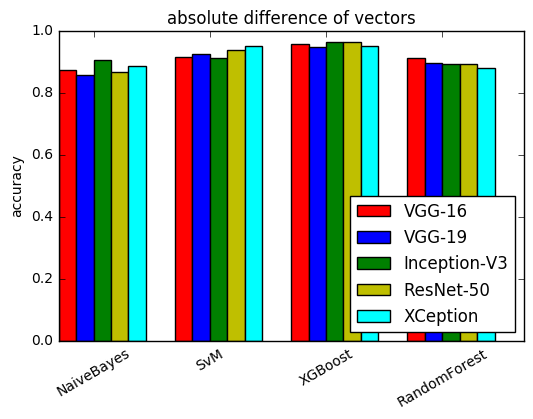

In [33]:
width=0.15
plt.bar(np.arange(NUM_CLASSIFIERS), scores[0], width, color="r", label="VGG-16")
plt.bar(np.arange(NUM_CLASSIFIERS)+width, scores[1], width, color="b", label="VGG-19")
plt.bar(np.arange(NUM_CLASSIFIERS)+2*width, scores[2], width, color="g", label="Inception-V3")
plt.bar(np.arange(NUM_CLASSIFIERS)+3*width, scores[3], width, color="y", label="ResNet-50")
plt.bar(np.arange(NUM_CLASSIFIERS)+4*width, scores[4], width, color="cyan", label="XCeption")
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xticks(np.arange(NUM_CLASSIFIERS)+2*width, ["NaiveBayes", "SvM", "XGBoost", "RandomForest"],
          rotation=30)
plt.title("absolute difference of vectors")